In [1]:
from __future__ import absolute_import
from __future__ import print_function
import os

import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,TensorBoard

from keras import backend as K

import cv2
import numpy as np
import json
np.random.seed(7) # 0bserver07 for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_shape = 360*480

class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


# load the model:
with open('segNet_basic_dropout_model.json') as model_file:
    segnet_basic = models.model_from_json(model_file.read())

# Compile model (required to make predictions)
segnet_basic.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])


In [3]:
segnet_basic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 360, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 360, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 360, 480, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 240, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 240, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 180, 240, 128)     512       
__________

In [4]:
# load the data
train_data = np.load('./data/train_data.npy')
train_label = np.load('./data/train_label.npy')

In [5]:
valid_data = np.load('./data/val_data.npy')
valid_label = np.load('./data/val_label.npy')

In [7]:

test_data = np.load('./data/test_data.npy')
test_label = np.load('./data/test_label.npy')

In [6]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
callbacks_list = [checkpoint,tensorboard]

In [7]:
history = segnet_basic.fit(train_data, train_label, batch_size=3, epochs=45,
                    verbose=1, class_weight=class_weighting , validation_data=(valid_data, valid_label),
                    shuffle=True, callbacks=callbacks_list) # validation_split=0.33

Train on 367 samples, validate on 101 samples
Epoch 1/45
367/367 [==============================] - 107s 290ms/step - loss: 1.2641 - acc: 0.6193 - val_loss: 2.0173 - val_acc: 0.5045

Epoch 00001: val_acc improved from -inf to 0.50454, saving model to weights.best.hdf5
Epoch 2/45
367/367 [==============================] - 100s 272ms/step - loss: 0.9591 - acc: 0.7024 - val_loss: 4.3866 - val_acc: 0.5009

Epoch 00002: val_acc did not improve
Epoch 3/45
367/367 [==============================] - 100s 273ms/step - loss: 0.8420 - acc: 0.7398 - val_loss: 2.2091 - val_acc: 0.5337

Epoch 00003: val_acc improved from 0.50454 to 0.53370, saving model to weights.best.hdf5
Epoch 4/45
367/367 [==============================] - 100s 272ms/step - loss: 0.7679 - acc: 0.7600 - val_loss: 1.4061 - val_acc: 0.5774

Epoch 00004: val_acc improved from 0.53370 to 0.57743, saving model to weights.best.hdf5
Epoch 5/45
367/367 [==============================] - 100s 272ms/step - loss: 0.7256 - acc: 0.7741 - val_

KeyboardInterrupt: 

In [14]:
batch_size = 6

# estimate accuracy on whole dataset using loaded weights
# load weights
#segnet_basic.load_weights("weights.best.hdf5")
scores = segnet_basic.evaluate(test_data, test_label, verbose=0, batch_size=batch_size)
print("%s: %.2f%%" % (segnet_basic.metrics_names[1], scores[1]*100))

acc: 80.67%


In [15]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb


shape of output is: (1, 360, 480, 12)


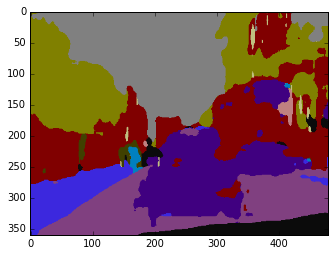

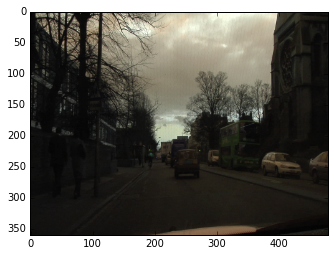

In [19]:
import os
DataPath = './CamVid/'

gt = []
with open(DataPath+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

# with open(DataPath+'test.txt') as f:
#     txt = f.readlines()
#     txt = [line.split(' ') for line in txt]
# for i in range(len(txt)):
#     gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))
    
    

output = segnet_basic.predict_proba(test_data[15:16])
print("shape of output is:",output.shape)
#pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
output = output.reshape(360,480,12)
pred = visualize(np.argmax(output,axis=2), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[15])

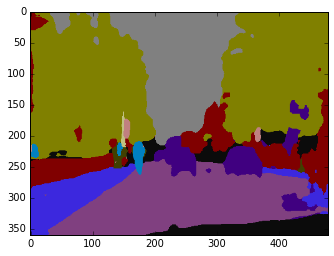

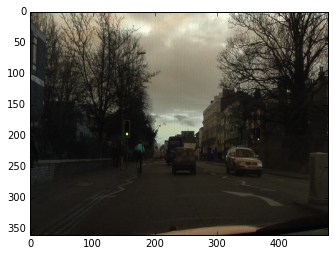

In [20]:
output = segnet_basic.predict_proba(train_data[20:21])
#pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
output = output.reshape(360,480,12)
pred = visualize(np.argmax(output,axis=2), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[20])

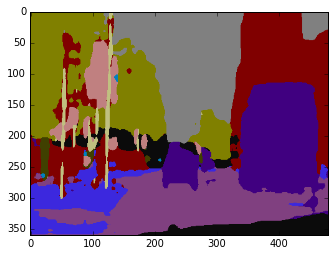

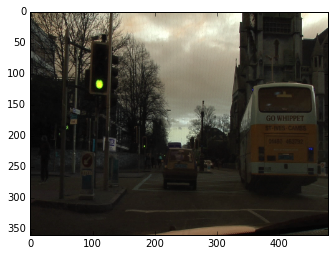

In [21]:
output = segnet_basic.predict_proba(train_data[10:11])
#pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
output = output.reshape(360,480,12)
pred = visualize(np.argmax(output,axis=2), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[10])

In [19]:
# choose any image to want by specifying the index
img_to_visualize = train_data[10:11]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.

# works without extra dimensionm ?? why


#img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

In [20]:
def layer_to_visualize(layer_count):
    inputs = [K.learning_phase()] + segnet_basic.inputs

    outputs = [layer.output for layer in segnet_basic.layers]          # all layer outputs
    
    #layer = segnet_basic.layers[layer_count]
    #_convout1_f = K.function(inputs, [layer.output])
    _convout1_f = K.function(inputs, [outputs[layer_count]])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    
    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

Shape of conv: (360, 480, 64)


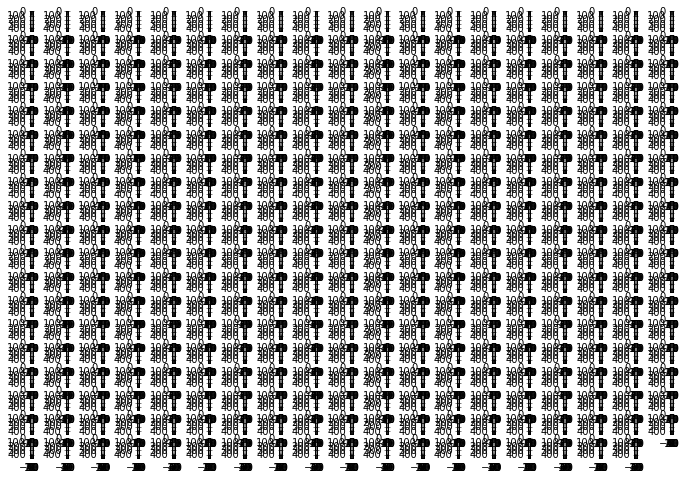

In [21]:
# Specify the layer to want to visualize
layer_to_visualize(2)

# As convout2 is the result of a MaxPool2D layer
# We can see that the image has blurred since
# the resolution has reduced 

#layer_to_visualize(2)

In [22]:
segnet_basic.save_weights('weights/model_weight_{}.hdf5'.format(45))